C:\Users\nimay\AppData\Local\Programs\Python\Python313\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Columns: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name='Price')
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Sample data:
Price              Open         High          Low        Close    Volume
Date                                                                    
2021-01-01  1156.420312  1163.407168  1154.489750  1158.764526   4253550
2021-01-04  1166.624751  1185.930598  1159.408064  1184.321777   7208454
2021-01-05  1178.576101  1194.204645  1172.186829  1189.424194   8145280
2021-01-06  1195.124052  1196.962705  1165.751625  1178.668091   7161715
2021-01-07  1191.446682  1192.963593  1154.213973  1160.327515  10954918
Start                     2021-01-01 00:00:00
End                       2024-12-30 00:00:00
Duration                   1459 days 00:00:00
Exposure Time [%]                    17.64706
Equity Final [$]                 194097.70936
Equity Peak [$]                  194097.70936
Commissions [$]                     442.03701

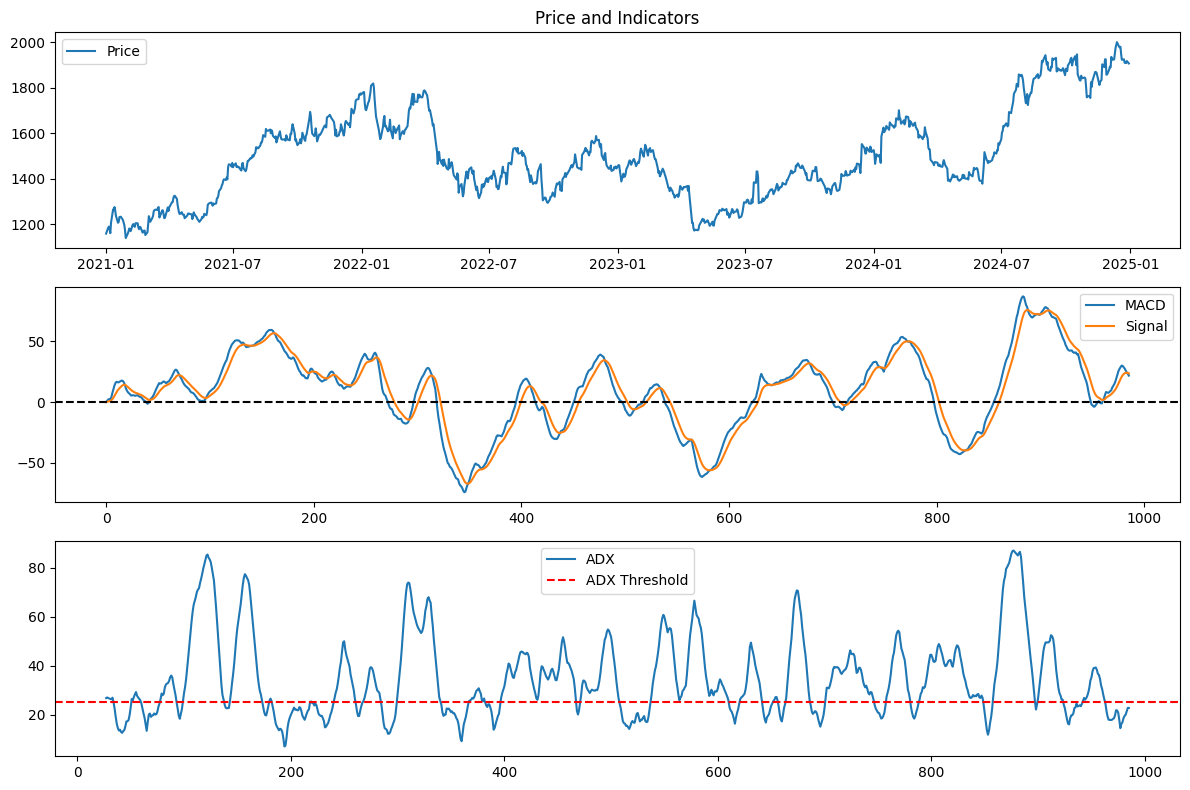

[*********************100%***********************]  1 of 1 completed


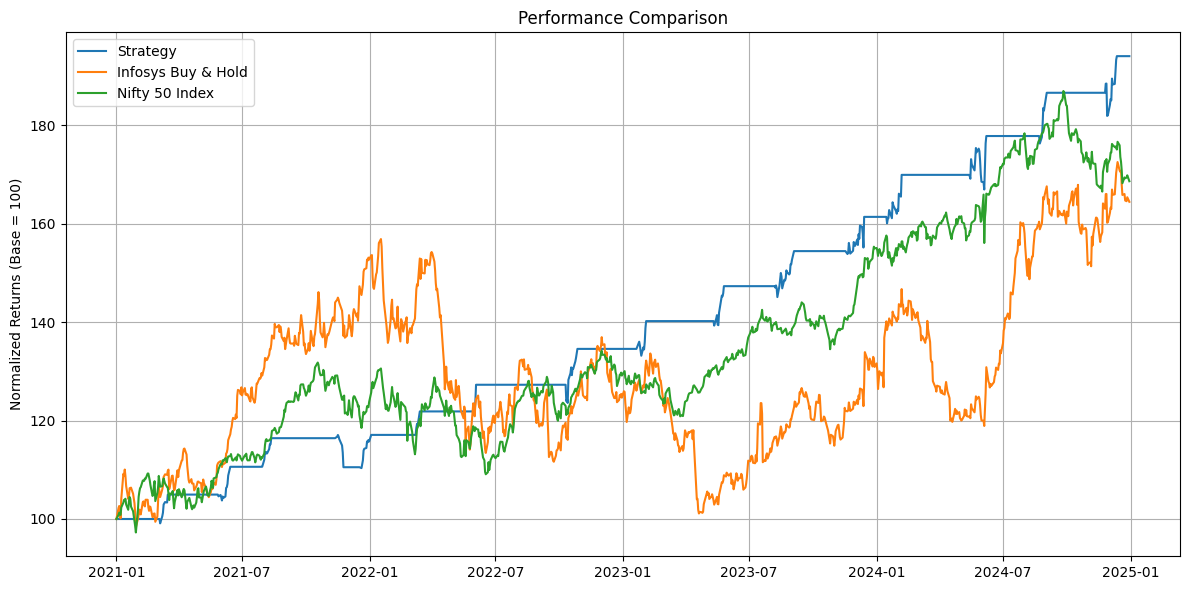


--- Cumulative Returns ---
Strategy: 94.10%
Infosys Buy & Hold: 64.49%
Nifty 50 Index: 68.67%

--- Strategy Performance ---
Sharpe Ratio: 1.97
Sortino Ratio: 4.74
Max Drawdown: -5.75%
Win Rate: 93.75%

--- Annualized Return ---
CAGR: 12.14%

--- Profit Factor Metrics ---
Profit Factor        17.08
Average Profit    6,694.69
Average Loss     -5,880.63
Maximum Profit    8,828.93
Maximum Loss     -5,880.63


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import matplotlib.pyplot as plt

# --- Indicator Functions ---
def EMA(series, period):
    series = pd.Series(series)
    return series.ewm(span=period, adjust=False).mean().values

def MACD(close, fast=25, slow=50, signal=12):
    close = pd.Series(close)
    macd = EMA(close, fast) - EMA(close, slow)
    signal_line = pd.Series(macd).ewm(span=signal, adjust=False).mean().values
    return np.array(macd), np.array(signal_line)

def ADX(high, low, close, period=14):
    high = pd.Series(high)
    low = pd.Series(low)
    close = pd.Series(close)
    
    df = pd.DataFrame({'High': high, 'Low': low, 'Close': close})
    df['TR'] = np.maximum.reduce([
        df['High'] - df['Low'],
        abs(df['High'] - df['Close'].shift()),
        abs(df['Low'] - df['Close'].shift())
    ])
    df['+DM'] = np.where((df['High'] - df['High'].shift()) > (df['Low'].shift() - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(), 0), 0)
    df['-DM'] = np.where((df['Low'].shift() - df['Low']) > (df['High'] - df['High'].shift()),
                         np.maximum(df['Low'].shift() - df['Low'], 0), 0)
    tr14 = df['TR'].rolling(window=period).sum()
    plus_dm14 = df['+DM'].rolling(window=period).sum()
    minus_dm14 = df['-DM'].rolling(window=period).sum()
    plus_di = 100 * (plus_dm14 / tr14)
    minus_di = 100 * (minus_dm14 / tr14)
    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
    adx = dx.rolling(window=period).mean()
    return adx.values

# --- Strategy ---
class ImprovedStrategy(Strategy):
    def init(self):
        close = self.data.Close
        self.ema_short = self.I(EMA, close, 25)
        self.ema_long = self.I(EMA, close, 50)
        self.macd, self.macd_signal = self.I(MACD, close)
        self.adx = self.I(ADX, self.data.High, self.data.Low, close)
        self.min_period = 50
        
    def next(self):
        macd_cross = crossover(self.macd, self.macd_signal)
        strong_trend = self.adx[-1] > 15  # Lower threshold to allow more trades
        close_to_ema = (abs(self.data.Close[-1] - self.ema_long[-1])/self.ema_long[-1] < 0.04)  # Allow 5% deviation
        
        # Now require MACD crossover and at least one favorable condition
        if macd_cross and (strong_trend or close_to_ema):
            if not self.position:
                self.buy(
                    sl=0.95 * self.data.Close[-1],
                    tp=1.0489 * self.data.Close[-1]
                )

    
# Example usage:
# Assuming you have a DataFrame 'trades_df' with a 'PnL' column
# metrics = calculate_profit_factor_metrics(trades_df)
# print(pd.Series(metrics))


# --- Download and Prepare Data ---
def prepare_data(ticker):
    df = yf.download(ticker, start="2021-01-01", end="2024-12-31")
    
    # Ensure we have the required columns
    required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # If columns are MultiIndex, flatten them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1) if df.columns.nlevels > 1 else df.columns
        
    # Select only the columns we need
    df = df[required_cols].copy()
    
    # Drop any rows with NaN values
    df = df.dropna()
    
    return df

# Download Infosys data
df_infy = prepare_data("INFY.NS")

# Verify data structure
print("Columns:", df_infy.columns)
print("Index type:", type(df_infy.index))
print("Sample data:")
print(df_infy.head())

def calculate_profit_factor_metrics(trades):
   
        # Filter out trades with zero PnL (if any)
        trades = trades[trades['PnL'] != 0]
        
        # Calculate winning and losing trades
        winning_trades = trades[trades['PnL'] > 0]
        losing_trades = trades[trades['PnL'] < 0]
        
        # Calculate basic metrics
        total_profit = winning_trades['PnL'].sum()
        total_loss = abs(losing_trades['PnL'].sum())
        profit_factor = total_profit / total_loss if total_loss != 0 else np.inf
        
        # Calculate average profit/loss
        avg_profit = winning_trades['PnL'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['PnL'].mean() if len(losing_trades) > 0 else 0
        
        # Calculate max profit/loss
        max_profit = winning_trades['PnL'].max() if len(winning_trades) > 0 else 0
        max_loss = losing_trades['PnL'].min() if len(losing_trades) > 0 else 0
        
        # Calculate win rate
        win_rate = len(winning_trades) / len(trades) if len(trades) > 0 else 0
        
        # Calculate profit/loss ratio
        profit_loss_ratio = abs(avg_profit / avg_loss) if avg_loss != 0 else np.inf
        
        # Prepare metrics dictionary
        metrics = {
            'Profit Factor': profit_factor,
            'Average Profit': avg_profit,
            'Average Loss': avg_loss,
            'Maximum Profit': max_profit,
            'Maximum Loss': max_loss,
        }
        return metrics


# --- Run Backtest ---
bt = Backtest(df_infy, ImprovedStrategy, cash=100000, commission=0.0001)
results = bt.run()
print(results)
trades_df = results._trades
profit_metrics = calculate_profit_factor_metrics(trades_df)
print(pd.Series(profit_metrics))

# Add this after your backtest
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.title('Price and Indicators')
plt.plot(df_infy['Close'], label='Price')
plt.legend()

plt.subplot(312)
plt.plot(results._strategy.macd, label='MACD')
plt.plot(results._strategy.macd_signal, label='Signal')
plt.axhline(0, color='black', linestyle='--')
plt.legend()

plt.subplot(313)
plt.plot(results._strategy.adx, label='ADX')
plt.axhline(25, color='red', linestyle='--', label='ADX Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# --- Download Benchmark Data ---
df_nifty = prepare_data("^NSEI")  # Nifty 50 index.

# Tag regimes on Nifty data
df_nifty['SMA_50'] = df_nifty['Close'].rolling(window=50).mean()
df_nifty['SMA_200'] = df_nifty['Close'].rolling(window=200).mean()
df_nifty['Regime'] = np.where(
    df_nifty['SMA_50'] > df_nifty['SMA_200'], 'Bull',
    np.where(df_nifty['SMA_50'] < df_nifty['SMA_200'], 'Bear', 'Sideways')
)

# Merge regime info with Infosys data
df_infy = df_infy.copy()
df_infy['Regime'] = df_nifty['Regime']
df_infy.dropna(inplace=True)


# --- Calculate and Plot Returns ---
def calculate_normalized_returns(price_series, base_date=None):
    if base_date is None:
        base_date = price_series.index[0]
    return price_series / price_series.loc[base_date] * 100

# Find common base date
base_date = max(df_infy.index[0], df_nifty.index[0])

# Calculate normalized returns
strategy_returns = calculate_normalized_returns(results._equity_curve['Equity'], base_date)
infosys_returns = calculate_normalized_returns(df_infy['Close'], base_date)
nifty_returns = calculate_normalized_returns(df_nifty['Close'], base_date)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(strategy_returns.index, strategy_returns, label='Strategy')
plt.plot(infosys_returns.index, infosys_returns, label='Infosys Buy & Hold')
plt.plot(nifty_returns.index, nifty_returns, label='Nifty 50 Index')

plt.title("Performance Comparison")
plt.ylabel("Normalized Returns (Base = 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Performance Metrics ---
def calculate_cumulative_return(series):
    return (series.iloc[-1] - series.iloc[0]) / series.iloc[0]

print("\n--- Cumulative Returns ---")
print(f"Strategy: {calculate_cumulative_return(results._equity_curve['Equity']) * 100:.2f}%")
print(f"Infosys Buy & Hold: {calculate_cumulative_return(df_infy['Close']) * 100:.2f}%")
print(f"Nifty 50 Index: {calculate_cumulative_return(df_nifty['Close']) * 100:.2f}%")

print("\n--- Strategy Performance ---")
print(f"Sharpe Ratio: {results['Sharpe Ratio']:.2f}")
print(f"Sortino Ratio: {results['Sortino Ratio']:.2f}")
print(f"Max Drawdown: {results['Max. Drawdown [%]']:.2f}%")
print(f"Win Rate: {results['Win Rate [%]']:.2f}%")

print("\n--- Annualized Return ---")
print(f"CAGR: {results['CAGR [%]']:.2f}%")

print("\n--- Profit Factor Metrics ---")
# Display as a formatted Series
metrics_series = pd.Series(profit_metrics)
print(metrics_series.to_string(float_format="{:,.2f}".format))

